### Group Project 4 : Comparing 3 Models for Predicting Recidivism

For background on this project, please see the [README](../README.md).

**Notebooks**
- [Data Acquisition & Cleaning](./01_data_acq_clean.ipynb)
- [Exploratory Data Analysis](./02_eda.ipynb)
- [Modeling](./03_modeling.ipynb)
- [Model Tuning](./04_tuning.ipynb)
- Experiments (this notebook)
- [Results and Recommendations](./05_results.ipynb)

**In this notebook, you'll find:**
- TODO etc.

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import balanced_accuracy_score, ConfusionMatrixDisplay, recall_score, f1_score, precision_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import ADASYN

**Model 1: Base feature set - New York**

**Model 2: Criminal history feature set - Florida**

- We're going to try vectorizing each person's list of charges and incorporating some NLP into our production model.
- We'll use TFIDF vectorization, and before merging the NLP columns into our production model, we'll use a GridSearch with a simple LogisticRegression to
determine the best parameters to use for TFIDF.

In [40]:
fl = pd.read_csv('../data/FL/FL_final.csv')

# drop all non-model columns - keeping agg_charges this time!
fl = fl.drop(columns = [
    'person_id',  # unique ID, not predictive
    'avg_days_between_offenses', 'avg_days_between_arrests', # only meaningful for recidivists
    'age_at_last_incarceration', 'age_at_last_release', 'age_at_last_arrest', # "last" columns are not predictive
] + [col for col in fl if col.startswith('comp_')] # not using COMPAS scores in the model
  + [col for col in fl if col.startswith('last_charge_')] # last charges are not predictive
)

In [41]:
# define X and y, train-test split
nlp = fl[['agg_charges', 'recidivism']].dropna()
X = nlp['agg_charges']
y = nlp['recidivism']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

# Pipeline with logreg
pipe = Pipeline(steps = [('tfidf', TfidfVectorizer()), ('logreg', LogisticRegression(max_iter = 10_000))])

pipe_params = {
    'tfidf__stop_words': [None, 'english'],
    'tfidf__max_features': [3000, 4000],
    'tfidf__min_df': [1, 2],
    'tfidf__max_df': [0.8, 0.9],
    'tfidf__ngram_range': [(1, 1), (1, 2)]
}

# search
gs = GridSearchCV(estimator = pipe, param_grid = pipe_params, n_jobs = -1)
gs.fit(X_train, y_train)

# score
model = gs.best_estimator_
preds = model.predict(X_test)

train_acc = model.score(X_train, y_train)
test_acc = model.score(X_test, y_test)
recall = recall_score(y_test, preds, pos_label = 1)
precision = precision_score(y_test, preds, pos_label = 1)
f1 = f1_score(y_test, preds, pos_label = 1)

print(f'training set accuracy: {train_acc}')
print(f'test set accuracy: {test_acc}')
print(f'recall: {recall}')
print(f'precision: {precision}')
print(f'f1 score: {f1}')

training set accuracy: 0.787673806839534
test set accuracy: 0.7550713749060857
recall: 0.6057416267942584
precision: 0.7250859106529209
f1 score: 0.6600625651720542


In [42]:
# what were our best parameters?
model

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.8, max_features=3000,
                                 ngram_range=(1, 2), stop_words='english')),
                ('logreg', LogisticRegression(max_iter=10000))])

In [43]:
# now we can apply our optimal vectorization
tfidf = TfidfVectorizer(max_df = 0.8, max_features = 3000, ngram_range = (1, 2), stop_words = 'english')
nlpcols = tfidf.fit_transform(fl['agg_charges'])

In [54]:
# and add the vectorized columns to our main dataframe
fl_nlp = pd.concat([fl, pd.DataFrame(nlpcols.todense(), columns = tfidf.get_feature_names_out())], axis = 1)

In [58]:
# define our final X and y, train-test split
X = fl_nlp.drop(columns = ['recidivism', 'agg_charges'])
y = fl_nlp['recidivism']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

# and scale
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

# and rebalance
adasyn = ADASYN(random_state = 42, sampling_strategy = 1.0)
X_train_sc, y_train = adasyn.fit_resample(X_train_sc, y_train)

In [59]:
X_train.shape

(7983, 3032)

84/84 [==============================] - 0s 1ms/step
training set accuracy: 0.9577807188034058
test set accuracy: 0.7498121857643127
recall: 0.6775119617224881
precision: 0.682738669238187
f1 score: 0.6801152737752162


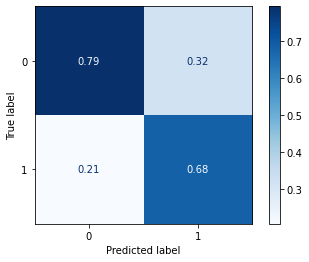

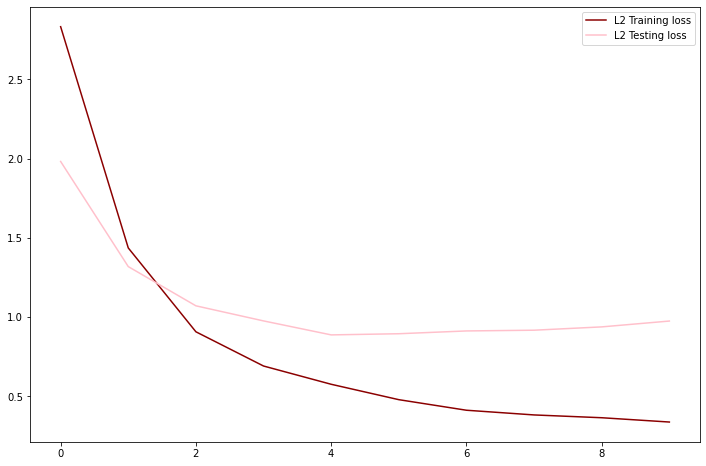

In [62]:
# L2-regularized FNN with early stopping
es = EarlyStopping(patience = 5)

# Model
model = Sequential()
model.add(Dense(units = 128, activation = 'relu', input_shape = (3032, ),
    kernel_regularizer = l2(0.01)))
model.add(Dense(units = 64, activation = 'relu', kernel_regularizer = l2(0.01)))
model.add(Dense(units = 1, activation = 'sigmoid'))

# Compile it
model.compile(optimizer = 'adam', loss = 'bce', metrics = ['acc'])

# Fit it
res = model.fit(x = X_train_sc, y = y_train, validation_data = (X_test_sc, y_test),
    epochs = 100, batch_size = 256, verbose = 0, callbacks = [es])

# Scores
train_acc = res.history['acc'][-1]
test_acc = res.history['val_acc'][-1]
preds = pd.Series(model.predict(X_test_sc)[:, 0]).map(lambda x: 1 if x >= 0.5 else 0)
recall = recall_score(y_test, preds, pos_label = 1)
precision = precision_score(y_test, preds, pos_label = 1)
f1 = f1_score(y_test, preds, pos_label = 1)
print(f'training set accuracy: {train_acc}')
print(f'test set accuracy: {test_acc}')
print(f'recall: {recall}')
print(f'precision: {precision}')
print(f'f1 score: {f1}')

ConfusionMatrixDisplay.from_predictions(y_test, preds, normalize = 'pred', cmap='Blues')

# Visualize
train_loss_l2 = res.history['loss']
test_loss_l2 = res.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss_l2, label='L2 Training loss', color='darkred')
plt.plot(test_loss_l2, label='L2 Testing loss', color='pink')
plt.legend();

CONCLUSIONS
- Looks like adding the NLP columns to the production model causes pretty major overfitting - possibly the result of trying such high-dimensional data with a neural network.
- We won't use the NLP columns. Worthwhile experiment though!

**Model 3: Behavioral feature set - Georgia**

**FINAL NOTES**
- TODO etc.
- The last notebook in the series is [Results and Recommendations](./05_results.ipynb).